In [ ]:
'''
Когортный анализ
'''

In [1]:
# Основные библиотеки
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from operator import attrgetter

# Библиотеки для работы с архивом
import zipfile
import io

In [2]:
archive = zipfile.ZipFile('Year 2010-2011.zip', 'r')
txtdata = archive.read('Year 2010-2011.csv')
df = pd.read_csv(io.BytesIO(txtdata), encoding='cp1251')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
'''
Cразу удалим пропущенные значения и дубликаты, поскольку они не входят в рамки нашей темы.
'''

In [3]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

df.describe()

,Quantity,Price,Customer ID
count,401605.000000,401605.000000,401605.000000
mean,12.183245,3.474100,15281.154341
std,250.282726,69.763952,1714.008869
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


In [ ]:
'''
В функциях «Количество» и «Цена» имеются отрицательные значени и нулевые значенияя. Это невозможно. Будем фильтровать данные больше нуля.
'''

In [4]:
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

In [ ]:
'''
Подготовка данных
Для когортного анализа нам нужны три метки. Это период оплаты, когортная группа и когортный период/индекс.

Для работы с временным рядом нам необходимо преобразовать тип связанного объекта. Формат должен быть таким же, как в наборе данных.
'''

In [5]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')

df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
'''
Теперь нам нужно создать переменные cohort и order_month. 
Первый указывает ежемесячную когорту на основе первой даты покупки, а второй — усеченный месяц с даты покупки.
'''

In [6]:
df['order_month'] = df['InvoiceDate'].dt.to_period('M')

df['cohort'] = df.groupby('Customer ID')['InvoiceDate'].transform('min').dt.to_period('M')

In [ ]:
'''
Затем мы агрегируем данные по когорте и order_month и подсчитываем количество уникальных клиентов в каждой группе.
'''

In [7]:
df_cohort = df.groupby(['cohort', 'order_month']).agg(n_customers=('Customer ID', 'nunique')).reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

df_cohort.head()

,cohort,order_month,n_customers,period_number
0,2010-12,2010-12,885,0
1,2010-12,2011-01,324,1
2,2010-12,2011-02,286,2
3,2010-12,2011-03,340,3
4,2010-12,2011-04,321,4


In [ ]:
'''
Затем мы агрегируем данные по когорте и order_month и подсчитываем количество уникальных клиентов в каждой группе.
'''

In [8]:
cohort_pivot = df_cohort.pivot_table(index='cohort', columns='period_number', values='n_customers')
cohort_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
'''
Преобразуем таблицу, чтобы лучше увидеть.
'''

In [9]:
cohort_size = cohort_pivot.iloc[:, 0]

In [10]:
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
retention_matrix

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,1.0,0.366102,0.323164,0.384181,0.362712,0.397740,0.362712,0.349153,0.353672,0.395480,0.374011,0.502825,0.265537
2011-01,1.0,0.220624,0.266187,0.230216,0.321343,0.287770,0.247002,0.242206,0.299760,0.326139,0.364508,0.117506,NaN
2011-02,1.0,0.186842,0.186842,0.284211,0.271053,0.247368,0.252632,0.278947,0.247368,0.305263,0.068421,NaN,NaN
2011-03,1.0,0.150442,0.252212,0.199115,0.223451,0.168142,0.267699,0.230088,0.278761,0.086283,NaN,NaN,NaN
2011-04,1.0,0.213333,0.203333,0.210000,0.196667,0.226667,0.216667,0.260000,0.073333,NaN,NaN,NaN,NaN
2011-05,1.0,0.190141,0.172535,0.172535,0.207746,0.232394,0.264085,0.095070,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.173554,0.157025,0.264463,0.231405,0.334711,0.095041,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.180851,0.207447,0.223404,0.271277,0.111702,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.207101,0.248521,0.242604,0.124260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
'''
Рисуем матрицу удержания в виде тепловой карты. 
Кроме того, мы хотели включить дополнительную информацию о размере когорты. 
Вот почему мы фактически создали две тепловые карты, причем та, которая указывает размер когорты, 
использует только белый цвет.
'''

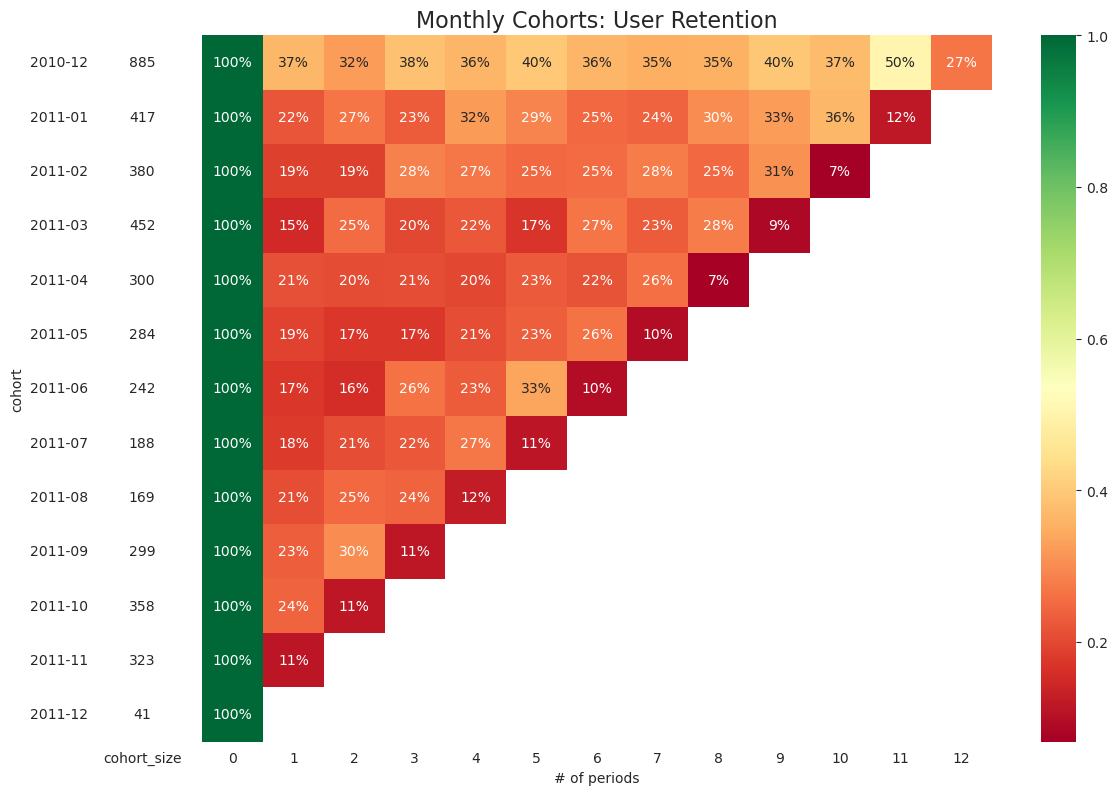

In [11]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # матрица удержания
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # размер когорты
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

In [ ]:
'''
На изображении мы видим, что уже во втором месяце (индексируется как 1) наблюдается резкий спад: 
в среднем около 80% клиентов не совершают никаких покупок во втором месяце. 
Первая когорта (2010–2011 гг.), кажется, является исключением и демонстрирует на удивление хорошие результаты 
по сравнению с остальными. Через год после первой покупки сохраняется 50%. 
Это может быть группа преданных клиентов, которые впервые присоединились к платформе на основе уже существующих связей 
с ритейлером. 
Однако, исходя только из данных, это очень сложно точно объяснить.

По всей матрице мы можем видеть колебания удержания с течением времени. 
Это может быть вызвано особенностями бизнеса, когда клиенты совершают периодические покупки, 
за которыми следуют периоды бездействия.
'''